Jonathon Nguyen

ID: 801093003

Homework 3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets
import torch.optim as optim

import time
import datetime
import numpy as np
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt

<b>Problem 1a</b>  
Build a Convolutional Neural Network, like what we built in lectures (without skip connections), to classify the images across all 10 classes in CIFAR 10. 

You need to adjust the fully connected layer at the end properly with respect to the number of output classes. Train your network for 300 epochs. 

Report your training time, training loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare them against a fully connected network (homework 2) on training time, achieved accuracy, and model size. Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [2]:
class CNN(nn.Module):
    def __init__(self, n_channels1 = 32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_channels1, (self.n_channels1 // 2), kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * (self.n_channels1 // 2), 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = f.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * (self.n_channels1 // 2))
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [3]:
def training_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        # Temp vars for use in finding the accuracy.
        correct_labels = 0
        count = 0
        loss_val_value = 0
        
        #Set the model to inference mode
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                # Move the data to correct device
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                # Pass imgs through the model and find the loss.
                output = model(imgs)
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)
                
                # Find the accurcey of the model.
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            
            # Store the loss and accuracy.
            loss_val_value /= len(val_loader)
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count)
        
        #Set the model to training mode.
        model.train()
        loss_train_value = 0
        for imgs, labels in train_loader:
            # Move the data to correct device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            # Pass imgs through the model and find the loss.
            output = model(imgs)
            loss_train = loss_fn(output, labels)
            loss_train_value += float(loss_train)
            
            # Adject the params
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Store the loss
        loss_train_value /= len(train_loader)
        training_losses.append(loss_train_value)
        
        # Print out the loss every 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train_value}", end="")
            print(f", Validation Loss: {loss_val_value}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

In [4]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

In [5]:
# Download the cifar10 dataset.
data = '.\cifar10'
cirfar10_train = datasets.CIFAR10(data, train=True, download=True, transform=transforms)
cirfar10_val = datasets.CIFAR10(data, train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f"Training on {device}")

Training on cuda


In [7]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

model = CNN().to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [8]:
try:
    # Using time to time the training.
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)
finally:
    # Close the threads
    try:
        train_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Training loader]: Could not shutdown the workers. Might not have spawn yet.")

    try:
        val_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Validation loader]: Could not shutdown the workers. Might not have spawn yet.")

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.305602535909536, Validation Loss: 2.3121751308441163, Accuracy: 10.11%
Epoch: 10, Training Loss: 1.9291672998545122, Validation Loss: 1.9370896935462951, Accuracy: 31.990000000000002%
Epoch: 20, Training Loss: 1.6594633472209075, Validation Loss: 1.6585296273231507, Accuracy: 41.449999999999996%
Epoch: 30, Training Loss: 1.498929965252779, Validation Loss: 1.4898319244384766, Accuracy: 47.03%
Epoch: 40, Training Loss: 1.404080512572308, Validation Loss: 1.38954336643219, Accuracy: 50.32%
Epoch: 50, Training Loss: 1.3129716357406305, Validation Loss: 1.3112048983573914, Accuracy: 53.080000000000005%
Epoch: 60, Training Loss: 1.250903961609821, Validation Loss: 1.274636197090149, Accuracy: 54.769999999999996%
Epoch: 70, Training Loss: 1.2004633825652453, Validation Loss: 1.2412559151649476, Accuracy: 55.60000000000001%
Epoch: 80, Training Loss: 1.1685705890460891, Validation Loss: 1.180311143398285, Accuracy: 58.29%
Epoch: 90, Training Loss: 1.1148327467392902,

Text(0.5, 1.0, 'Problem 1a Losses')

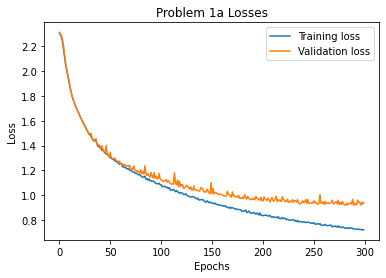

In [9]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Problem 1a Losses")

Text(0.5, 1.0, 'Problem 1a Accuracy')

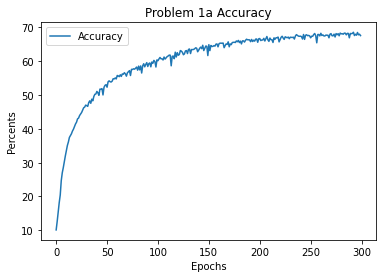

In [10]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Problem 1a Accuracy")

<b>Problem 1b</b>  
Extend your CNN by adding one more additional convolution layer followed by an activation function and pooling function. 

You also need to adjust your fully connected layer properly with respect to intermediate feature dimensions. 

Train your network for 300 epochs. Report your training time, loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [11]:
class CNN2(nn.Module):
    def __init__(self, n_channels1 = 32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_channels1, (self.n_channels1 // 2), kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d((self.n_channels1 // 2), (self.n_channels1 // 4), kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(4 * 4 * (self.n_channels1 // 4), 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = f.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = f.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * (self.n_channels1 // 4))
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024

model = CNN2().to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [13]:
try:
    # Using time to time the training.
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)
finally:
    # Close the threads
    try:
        train_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Training loader]: Could not shutdown the workers. Might not have spawn yet.")

    try:
        val_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Validation loader]: Could not shutdown the workers. Might not have spawn yet.")

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 2.3107252412912795, Validation Loss: 2.3120309114456177, Accuracy: 8.450000000000001%
Epoch: 10, Training Loss: 2.225430070137491, Validation Loss: 2.241087627410889, Accuracy: 16.509999999999998%
Epoch: 20, Training Loss: 1.919831531388419, Validation Loss: 1.9262834191322327, Accuracy: 30.85%
Epoch: 30, Training Loss: 1.771781408056921, Validation Loss: 1.7778437852859497, Accuracy: 36.55%
Epoch: 40, Training Loss: 1.6699672888736337, Validation Loss: 1.67917320728302, Accuracy: 39.26%
Epoch: 50, Training Loss: 1.5859574055185124, Validation Loss: 1.5968814849853517, Accuracy: 42.309999999999995%
Epoch: 60, Training Loss: 1.5406970272258835, Validation Loss: 1.5358842253684997, Accuracy: 44.06%
Epoch: 70, Training Loss: 1.4918825675030143, Validation Loss: 1.4969459056854248, Accuracy: 45.48%
Epoch: 80, Training Loss: 1.4478091877333972, Validation Loss: 1.4377393960952758, Accuracy: 47.599999999999994%
Epoch: 90, Training Loss: 1.393387383344222, Validation 

Text(0.5, 1.0, 'Problem 1b Losses')

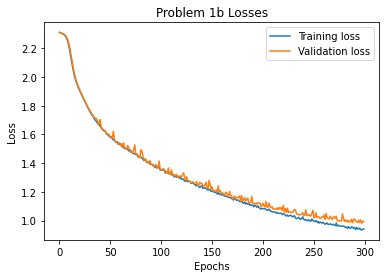

In [14]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Problem 1b Losses")

Text(0.5, 1.0, 'Problem 1b Accuracy')

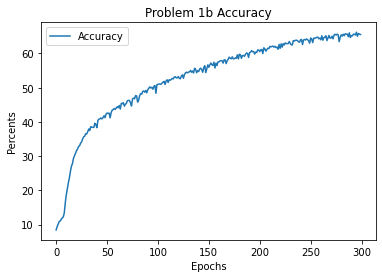

In [15]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Problem 1b Accuracy")

In [16]:
from ptflops import get_model_complexity_info

model_p1a = CNN()
model_p1b = CNN2()

macs, params = get_model_complexity_info(model_p1a, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the Model size.
print("Problem 1 Part a")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model_p1b, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the Model size.
print("Problem 1 Part b")
print("Model size: " + params)

Problem 1 Part a
Model size: 38.65 k

Problem 1 Part b
Model size: 11.14 k


<b>Problem 2a</b>  
Build a ResNet based Convolutional Neural Network, like what we built in lectures (with skip connections), to classify the images across all 10 classes in CIFAR 10. For this problem, let’s use 10 blocks for ResNet and call it ResNet-10.  
Use the similar dimensions and channels as we need in lectures. 
  
Train your network for 300 epochs. Report your training time, training loss, and evaluation accuracy after 300 epochs. 
  
Analyze your results in your report and compare them against problem 1.b on training time, achieved accuracy, and model size. 
Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [7]:
class ResBlock(nn.Module):
    def __init__(self, n_channels1):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_channels1, n_channels1, kernel_size = 3, padding = 1)
        
    def forward(self, x):
        out = self.conv(x)
        return torch.relu(out + x)

In [8]:
class ResNet(nn.Module):
    def __init__(self, n_channels1, n_blocks):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.blocks = nn.Sequential(*(n_blocks * [ResBlock(n_channels1=self.n_channels1)]))
        self.fc1 = nn.Linear(8 * 8 * self.n_channels1, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = f.max_pool2d(self.blocks(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [9]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10

model = ResNet(NUM_CHANNELS, BLOCKS).to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [16]:
try:
    # Using time to time the training.
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)
finally:
    # Close the threads
    try:
        train_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Training loader]: Could not shutdown the workers. Might not have spawn yet.")

    try:
        val_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Validation loader]: Could not shutdown the workers. Might not have spawn yet.")

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

'NoneType' object has no attribute '_shutdown_workers'
[Training loader]: Could not shutdown the workers. Might not have spawn yet.
'NoneType' object has no attribute '_shutdown_workers'
[Validation loader]: Could not shutdown the workers. Might not have spawn yet.


KeyboardInterrupt: 

Text(0.5, 1.0, 'Problem 2a Losses')

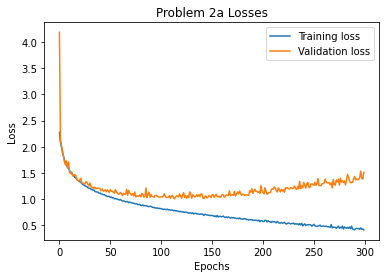

In [49]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Problem 2a Losses")

Text(0.5, 1.0, 'Problem 2a Accuracy')

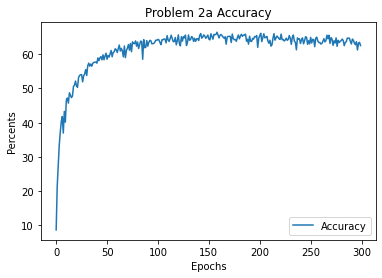

In [50]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Problem 2a Accuracy")

<b>Problem 2b</b>  
Develop three additional trainings and evaluations for your ResNet-10 to assess the impacts of regularization to your ResNet-10.  

- Weight Decay with lambda of 0.001  
- Dropout with p=0.3  
- Batch Normalization
  
Report and compare your training time, training loss, and evaluation accuracy after 300 epochs across these three different trainings. Analyze your results in your report and compare them against problem 1.a on training time, achieved accuracy.

In [10]:
class ResBlockDropout(nn.Module):
    def __init__(self, n_channels1, p):
        super(ResBlockDropout, self).__init__()
        self.conv = nn.Conv2d(n_channels1, n_channels1, kernel_size = 3, padding = 1)
        self.dropout = nn.Dropout2d(p = p)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = torch.relu(out)
        return out + x
    
class ResNetDropout(nn.Module):
    def __init__(self, n_channels1, n_blocks, p):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.blocks = nn.Sequential(*(n_blocks * [ResBlockDropout(n_channels1 = self.n_channels1, p = p)]))
        self.dropout = nn.Dropout2d(p = p)
        self.fc1 = nn.Linear(8 * 8 * self.n_channels1, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.dropout(self.conv1(x))), 2)
        out = f.max_pool2d(self.blocks(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
class ResBlockBatchNorm(nn.Module):
    def __init__(self, n_channels1):
        super(ResBlockBatchNorm, self).__init__()
        self.conv = nn.Conv2d(n_channels1, n_channels1, kernel_size = 3, padding = 1, bias = False)
        self.batch_norm = nn.BatchNorm2d(num_features = n_channels1)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    
    
class ResNetBatchNorm(nn.Module):
    def __init__(self, n_channels1, n_blocks):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, self.n_channels1, kernel_size = 3, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(num_features = n_channels1)
        self.blocks = nn.Sequential(*(n_blocks * [ResBlockBatchNorm(n_channels1=self.n_channels1)]))
        self.batchnorm2 = nn.BatchNorm2d(num_features = n_channels1)
        self.fc1 = nn.Linear(8 * 8 * self.n_channels1, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = f.max_pool2d(torch.relu(self.batchnorm1(self.conv1(x))), 2)
        out = f.max_pool2d(self.batchnorm2(self.blocks(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
def training_loopl2(epochs, optimizer, model, loss_fn, train_loader, val_loader, l2_lambda):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        # Temp vars for use in finding the accuracy.
        correct_labels = 0
        count = 0
        loss_val_value = 0
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                # Move the data to correct device
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                # Pass imgs through the model and find the loss.
                output = model(imgs)
                loss_val = loss_fn(output, labels)
                loss_val_value += float(loss_val)
                
                # Find the accurcey of the model.
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
            
            # Store the loss and accuracy.
            loss_val_value /= len(val_loader)
            val_losses.append(loss_val_value)
            accuracies.append(correct_labels/count)
        
        loss_train_value = 0
        model.train()
        for imgs, labels in train_loader:
            # Move the data to correct device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            # Pass imgs through the model and find the loss.
            output = model(imgs)
            loss_train = loss_fn(output, labels)
            
            # Perform L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss_train = loss_train + l2_lambda * l2_norm
            loss_train_value += float(loss_train)
            
            # Adject the params
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Store the loss
        loss_train_value /= len(train_loader)
        training_losses.append(loss_train_value)
        
        # Print out the loss every 10 epoch
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}, Training Loss: {loss_train_value}", end="")
            print(f", Validation Loss: {loss_val_value}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

<b>L2 regularization</b> 

In [13]:
NUM_EPOCHS = 300
LEARNING_RATE = 3e-3
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10
LAMBDA = 0.001 

model = ResNet(NUM_CHANNELS, BLOCKS).to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [ ]:
try:
    # Using time to time the training.
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loopl2(NUM_EPOCHS, optimizer, model, 
                                                              loss, train_loader, val_loader, LAMBDA)
    end_time = time.time()
except Exception as err:
    print(err)
finally:
    # Close the threads
    try:
        train_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Training loader]: Could not shutdown the workers. Might not have spawn yet.")

    try:
        val_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Validation loader]: Could not shutdown the workers. Might not have spawn yet.")

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: nan, Validation Loss: 12.043757724761964, Accuracy: 9.71%
Epoch: 10, Training Loss: nan, Validation Loss: nan, Accuracy: 10.0%
Epoch: 20, Training Loss: nan, Validation Loss: nan, Accuracy: 10.0%
Epoch: 30, Training Loss: nan, Validation Loss: nan, Accuracy: 10.0%


In [ ]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Problem 2b Losses (L2 regularization)")

In [ ]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Problem 2b Accuracy (L2 regularization)")

<b>Dropout</b> 

In [ ]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10
DROPOUT_RATE = 0.3

model = ResNetDropout(NUM_CHANNELS, BLOCKS, DROPOUT_RATE).to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [ ]:
try:
    # Using time to time the training.
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)
finally:
    # Close the threads
    try:
        train_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Training loader]: Could not shutdown the workers. Might not have spawn yet.")

    try:
        val_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Validation loader]: Could not shutdown the workers. Might not have spawn yet.")

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

In [ ]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Problem 2b Losses (Dropout)")

In [ ]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Problem 2b Accuracy (Dropout)")

<b>Batch Normalization</b> 

In [ ]:
NUM_EPOCHS = 300
LEARNING_RATE = 1e-2
BATCH_SIZE = 1024
NUM_CHANNELS = 32
BLOCKS = 10

model = ResNetBatchNorm(NUM_CHANNELS, BLOCKS).to(device=device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Load the data into a dataloaders.
train_loader = torch.utils.data.DataLoader(cirfar10_train, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           pin_memory=True, 
                                           persistent_workers=True, 
                                           num_workers=6)

val_loader = torch.utils.data.DataLoader(cirfar10_val, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         pin_memory=True, 
                                         persistent_workers=True, 
                                         num_workers=3)

In [ ]:
try:
    # Using time to time the training.
    start_time = time.time()
    training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
    end_time = time.time()
except Exception as err:
    print(err)
finally:
    # Close the threads
    try:
        train_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Training loader]: Could not shutdown the workers. Might not have spawn yet.")

    try:
        val_loader._iterator._shutdown_workers()
    except Exception as err:
        print(err)
        print("[Validation loader]: Could not shutdown the workers. Might not have spawn yet.")

# Report the final stats about the training.
print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1] * 100}%")
print(f"Training Time: {(end_time - start_time):.2f} seconds")

In [ ]:
# Plotting the Losses

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Problem 2b Losses (Batch Normalization)")

In [ ]:
# Plotting the accuracy of the model.

fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Percents")

for i, x in enumerate(accuracies):
    accuracies[i] = x * 100
    

plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.title("Problem 2b Accuracy (Batch Normalization)")

In [ ]:
model_l2 = ResNet(32, 10)
model_dropout = ResNetDropout(32, 10, 0.3)
model_batchnorm = ResNetBatchNorm(32, 10)

macs, params = get_model_complexity_info(model_l2, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the Model size.
print("L2 regularization")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model_dropout, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the Model size.
print("Dropout")
print("Model size: " + params)

print("")

macs, params = get_model_complexity_info(model_batchnorm, (3, 32, 32), as_strings=True,
 print_per_layer_stat=False, verbose=False)
# print out the Model size.
print("Batch Normalization")
print("Model size: " + params)